In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
from card_game import CardGame, Player, Card
import random

player = 1

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class RandomPlayer(Player):
    """
    Makes random moves (but according to the rules)
    """
    def __init__(self):
        global player
        self.number = player
        player += 1

    def make_move(self, game_state: dict, was_previous_move_wrong: bool) -> Card:
        if not game_state["discard"]:
            return random.choice(game_state["hand"])
        else:
            options = list(filter(lambda card: card.suit == list(game_state["discard"])[0].suit, game_state["hand"]))
            if len(options) > 0:
                return random.choice(options)
            else:
                return random.choice(game_state["hand"])

    def get_name(self):
        return f"RandomPlayer{self.number}"

    def set_temp_reward(self, discarded_cards: dict, point_deltas: dict):
        pass

    def set_final_reward(self, points: dict):
        pass


In [4]:
%pip install jupyterplot

Note: you may need to restart the kernel to use updated packages.


In [5]:
from jupyterplot import ProgressPlot
import torch as t
min_loss = float('-inf')

In [6]:
def plot_loss(loss: float):
    global pp, min_loss
    if min_loss < loss: 
        min_loss = loss
        t.save(agent.qnet, "reinforce.pkt")
        print(f"Upgraded loss to: {loss}")
    pp.update(loss)
    

In [7]:
from agents import REINFORCEAgent
agent = REINFORCEAgent(512, False, 5e-4, layers=[256, 128, 128], queue_size=40240, importance_weighting=True)
agent.set_loss_callback(plot_loss)
game = CardGame(agent, RandomPlayer(), RandomPlayer(), RandomPlayer(), full_deck=False, display=False)

72 24


In [8]:
game.players[0]

REINFORCEAgent(
  (qnet): Sequential(
    (0): Sequential(
      (0): Linear(in_features=72, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=24, bias=True)
      (1): Identity()
    )
  )
)

In [9]:
pp = ProgressPlot()
for _ in range(10000):
	game.start()
	last = agent.losses[-1]
	if last > -1e-3:
		break



<IPython.core.display.Javascript object>

Upgraded loss to: -175128.52080098822
Upgraded loss to: -134555.862432116
Upgraded loss to: -116789.38054392664
Upgraded loss to: -111098.67259384657
Upgraded loss to: -81922.483256804
Upgraded loss to: -70850.78855647858
Upgraded loss to: -42770.6872181216
Upgraded loss to: -35936.18434543682
Upgraded loss to: -29170.18728338868
Upgraded loss to: -27650.676320607858
Upgraded loss to: -17603.81139305772
Upgraded loss to: -16644.757907105
Upgraded loss to: -7622.276110151231
Upgraded loss to: -6097.7025139480265
Upgraded loss to: -4965.337390110799
Upgraded loss to: -3347.7013716965234
Upgraded loss to: -1724.6382581207504
Upgraded loss to: -1564.237600147535
Upgraded loss to: -1087.7660071478158
Upgraded loss to: -916.2056523146775
Upgraded loss to: -871.0253101629045
Upgraded loss to: -670.7474522754269
Upgraded loss to: -236.18883655615085
Upgraded loss to: -193.08449080217713
Upgraded loss to: -96.37471166204413
Upgraded loss to: -89.74163687016548
Upgraded loss to: -80.519154446275

In [10]:
agent.losses

[-175128.52080098822,
 -335024.33060421783,
 -516632.7177397364,
 -638941.3562002402,
 -790849.8668563456,
 -895937.2761747399,
 -1056299.1164290481,
 -1116710.0021000914,
 -1097369.7150842915,
 -1109636.2245360678,
 -1103765.5790998659,
 -1120271.1819301697,
 -1150706.0892011672,
 -1148933.2843649362,
 -1135120.1880950157,
 -1155456.5923877333,
 -1131840.3350232132,
 -1098807.384391493,
 -1099820.2265998684,
 -1073222.544054554,
 -1111966.9917260404,
 -1152477.0826740775,
 -1090228.953528536,
 -1105813.6947380714,
 -1127620.753098724,
 -1123881.9506991785,
 -1102614.240324529,
 -1118074.6402935502,
 -1119437.0609848313,
 -1114623.9017215706,
 -1099358.2759202141,
 -1101352.6744118393,
 -1115862.8065897303,
 -1083463.3255385407,
 -1111378.3219047892,
 -1094383.6360982065,
 -1085334.596338403,
 -1112144.486370477,
 -1122145.9638406448,
 -1099500.1579354915,
 -1117751.2274424974,
 -1148793.1204188727,
 -1095368.4103011694,
 -1083003.5591734985,
 -1059939.559049256,
 -1119862.280980114,
 

In [11]:
agent.training = False
agent.set_loss_callback(lambda x:x)

In [12]:
points = game.start()

In [13]:
points.values()

dict_values([84, 60, 21, 44])

In [14]:
wins = 0

In [15]:
import numpy as np

In [16]:
for _ in range(100):
	wins += int(np.argmin(list(game.start().values())) == 0)
print(f"Win ratio: {wins}%")

Win ratio: 30%


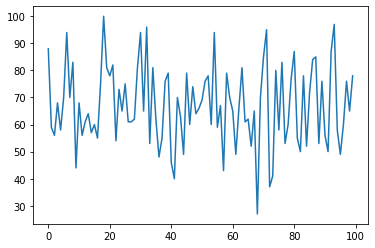

In [17]:
import matplotlib.pyplot as plt

plt.plot(agent.invalid_actions_per_episode[-100:])